# Eye for Blind – Image Captioning with Attention

# 1. Objective

Eye for Blind: An Assistive Image Captioning System with Visual Attention

This project implements a deep learning model that generates natural language descriptions of images, particularly aimed at visually impaired users. The model leverages an attention mechanism to selectively focus on image regions when generating each word, mimicking human vision.

Inspired by "Show, Attend and Tell" (Xu et al., 2015), this implementation:
1. Uses a CNN encoder (InceptionV3) to extract image features.
2. Applies additive (Bahdanau) attention during decoding.
3. Employs a decoder LSTM to generate captions.
4. Converts generated captions to speech using gTTS.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# 0 (default): All messages (INFO, WARNING, ERROR) are logged.
# 1: INFO messages are not printed.
# 2: INFO and WARNING messages are not printed.
# 3: INFO, WARNING, and ERROR messages are not printed.

import re
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
from typing import Dict, List, Tuple, Optional
import tensorflow as tf #type: ignore
from tensorflow.keras import layers, Model #type: ignore
from tensorflow.keras.optimizers.schedules import CosineDecay #type: ignore
from tensorflow.keras.losses import SparseCategoricalCrossentropy #type: ignore
from tensorflow.keras.preprocessing.text import Tokenizer #type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences #type: ignore
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction #type: ignore
from gtts import gTTS #type: ignore
from IPython.display import Audio, display
import tqdm

# 1. CONFIG

In [2]:
CONFIG: Dict[str, object] = {
    # Data
    'image_dir': '/home/flickr30k_images/flickr30k_images',
    'caption_file': '/home/flickr30k_images/flickr30k_images/results.csv',
    'subset_ratio': 1.0,

    # Vocabulary
    'vocab_min_count': 5,
    'max_length': 30,

    # Model
    'embedding_dim': 512,
    'units': 1024,
    'decoder_dropout': 0.3,

    # Optimiser / schedule
    'learning_rate': 5e-4,
    'grad_clip_value': 10.0,
    'scheduled_sampling_max_prob': 0.15,
    'mixed_precision': True,  # ← flip to True for AMP

    # Training loop
    'epochs': 30,
    'batch_size': 128,
    'buffer_size': 10_000,
    'early_stop': True,
    'patience': 20,

    # Checkpoints
    'checkpoint_dir': './checkpoints/full_run',
    'save_checkpoints': True,
    'delete_old_checkpoints': True,

    # Regulariser
    'attention_reg_lambda': 1.0,
    'seed': 42,
}

# 2. ENV‑SETUP & MIXED‑PRECISION POLICY


In [3]:
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
tf.random.set_seed(CONFIG['seed'])

# AMP policy (RTX 6000 Ada or any Tensor Core GPU)
if CONFIG['mixed_precision']:
    try:
        from tensorflow.keras import mixed_precision
    except ImportError:
        raise ImportError("Mixed precision requires TensorFlow ≥ 2.4")

    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("[AMP] mixed_float16 policy active ✨")
else:
    print("[AMP] disabled – using float32 throughout")

# Device placement (single‑GPU)
physical = tf.config.list_physical_devices('GPU')
if physical:
    for gpu in physical:
        tf.config.experimental.set_memory_growth(gpu, True)
    strategy = tf.distribute.get_strategy()
    print(f"Using {physical[0].name} | batch={CONFIG['batch_size']}")
else:
    strategy = tf.distribute.get_strategy()
    print("GPU not found – fallback to CPU")

AUTOTUNE = tf.data.AUTOTUNE

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA RTX 6000 Ada Generation, compute capability 8.9
[AMP] mixed_float16 policy active ✨
Using /physical_device:GPU:0 | batch=128


# 3. DATA PROCESSING

In [4]:
class DataProcessor:
    def __init__(self, config):
        self.config = config
        self.captions_dict = dict()
        self.tokenizer = None
        self.vocab_size = 0
        self.train_data = []
        self.val_data = []
        self.test_data = []
    
    def load_captions(self) -> Dict[str, List[str]]:
        """Load and convert pipe-delimited Flickr-style caption file to a dict."""
        print(f"Loading captions from {self.config['caption_file']}")
        df = pd.read_csv(self.config['caption_file'], sep='|', header=None, 
                         names=['image_name', 'comment_number', 'comment'], engine='python')
        df['image_name'] = df['image_name'].str.strip()
        df['comment'] = df['comment'].str.strip()
        
        caption_map = {}
        for img, group in df.groupby('image_name'):
            caption_map[img] = group['comment'].tolist()
        
        self.captions_dict = caption_map
        print(f"Loaded {len(caption_map)} images with captions")
        return caption_map
    
    def display_samples(self, num_samples: int = 3):
        """Display random images with all their associated captions."""
        if not self.captions_dict:
            self.load_captions()

        sample_keys = random.sample(list(self.captions_dict.keys()), min(num_samples, len(self.captions_dict)))

        for key in sample_keys:
            img_path = os.path.join(self.config['image_dir'], key)
            try:
                img = Image.open(img_path)
                plt.figure(figsize=(8, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.title(key)
                plt.show()

                for cap in self.captions_dict[key]:
                    print(f"- {cap}")
                print()
            except Exception as e:
                print(f"Error loading image {key}: {e}")

    def preprocess_caption(self, caption: str) -> str:
        """
        Clean and tag a single caption.

        Returns the processed caption string, or an empty string if the
        source caption is None / NaN / not a string.
        """
        if caption is None or not isinstance(caption, str) or caption.strip() == "":
            return ""
        caption = caption.lower()
        caption = re.sub(r"[^a-z0-9.,? ]", "", caption)
        return f"<start> {caption.strip()} <end>"

    def prepare_captions(self, subset_ratio=1.0):
        """Process captions, build tokenizer & train/val/test splits."""
        if not self.captions_dict:
            self.load_captions()

        # --- 1. clean & tag ----------------------------------------------------
        all_captions = []
        for caps in self.captions_dict.values():
            for c in caps:
                p = self.preprocess_caption(c)
                if p:
                    all_captions.append(p)

        word_counts = Counter(w for cap in all_captions for w in cap.split())
        valid_words = {w for w, cnt in word_counts.items()
                    if cnt >= self.config['vocab_min_count']}

        def keep(c):
            return all(w in valid_words or w in ('<start>', '<end>') for w in c.split())

        filtered = [c for c in all_captions if keep(c)]

        # --- 2. determine max length ------------------------------------------
        lengths = [len(c.split()) for c in filtered]
        self.config['max_length'] = int(np.percentile(lengths, 95))
        print(f"max_length set to {self.config['max_length']}")

        # --- 3. build tokenizer (NO filters so < and > stay) -------------------
        tokenizer = Tokenizer(oov_token="<unk>", filters='', lower=True)
        tokenizer.fit_on_texts(filtered)
        self.tokenizer = tokenizer
        self.vocab_size = len(tokenizer.word_index) + 1
        print(f"vocab size = {self.vocab_size}")

        # --- 4. Build (image, caption) pairs ------------------------------------
        pairs = []
        for img, caps in self.captions_dict.items():
            for c in caps:
                p = self.preprocess_caption(c)
                if p and keep(p):
                    pairs.append((img, p))

        # --- 5. Force fixed number of images if requested -----------------------
        if 'force_subset_images' in self.config and self.config['force_subset_images']:
            requested = self.config['force_subset_images']
            print(f"Forcing subset of exactly {requested} images...")
            all_imgs = list({img for img, _ in pairs})
            if requested > len(all_imgs):
                raise ValueError(f"Requested {requested} images, but only {len(all_imgs)} available.")
            selected_imgs = set(random.sample(all_imgs, requested))
            pairs = [(img, cap) for img, cap in pairs if img in selected_imgs]
            print(f"Subset contains {len(pairs)} (image, caption) pairs from {requested} images.")
        
        # --- 6. Subset by ratio if no forced image count ------------------------
        elif subset_ratio < 1.0:
            orig_len = len(pairs)
            pairs = pairs[:int(len(pairs) * subset_ratio)]
            print(f"Subset by ratio: {len(pairs)} pairs from {orig_len}")

        # --- 7. Split into train/val/test ---------------------------------------
        random.shuffle(pairs)
        n = len(pairs)
        self.train_data, self.val_data, self.test_data = (
            pairs[:int(0.8 * n)],
            pairs[int(0.8 * n):int(0.9 * n)],
            pairs[int(0.9 * n):]
        )
        print(f"split → train {len(self.train_data)} | val {len(self.val_data)} | test {len(self.test_data)}")

        return filtered

        
    def encode_caption(self, caption: str) -> Tuple[np.ndarray, int]:
        """Convert caption text to sequence of token ids."""
        if self.tokenizer is None:
            raise ValueError("Tokenizer not initialized. Call prepare_captions first.")
        
        seq = self.tokenizer.texts_to_sequences([caption])[0]
        padded_seq = pad_sequences([seq], maxlen=self.config['max_length'], padding='post')[0]
        return padded_seq, len(seq)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def _base_decode(self, path: tf.Tensor) -> tf.Tensor:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)          # [0,1]
        return img                                                   # (h,w,3)

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_train(self, path: tf.Tensor) -> tf.Tensor:
        """Augment + preprocess (training only)."""
        img = self._base_decode(path)
        img = tf.image.random_flip_left_right(img)                   # aug ①

        # resize shorter side→342 then *random* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.random_crop(img, size=[299, 299, 3])          # aug ②

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    @tf.function(input_signature=[tf.TensorSpec([], tf.string)])
    def load_image_eval(self, path: tf.Tensor) -> tf.Tensor:
        """Deterministic centre-crop (validation / inference)."""
        img = self._base_decode(path)

        # resize shorter side→342 then *central* crop 299×299
        shape = tf.shape(img)[:2]
        scale = 342. / tf.cast(tf.reduce_min(shape), tf.float32)
        new_hw = tf.cast(tf.cast(shape, tf.float32) * scale, tf.int32)
        img = tf.image.resize(img, new_hw)
        img = tf.image.resize_with_crop_or_pad(img, 299, 299)

        img = tf.keras.applications.inception_v3.preprocess_input(img)
        return tf.ensure_shape(img, [299, 299, 3])

    def data_generator(self, data):
        """
        Yield (image_tensor, token_ids, caption_len, filename)
        so the filename is always available for debug/analysis.
        """
        for img, cap in data:
            img_path  = os.path.join(self.config['image_dir'], img)
            img_tensor = self.load_image_train(tf.convert_to_tensor(img_path))
            token_ids, cap_len = self.encode_caption(cap)
            yield img_tensor, token_ids, cap_len, img 
    
    def build_dataset(self, data,
                      shuffle=True, cache=True, training: bool = True):

        output_signature = (
            tf.TensorSpec((299, 299, 3), tf.float32),               # image
            tf.TensorSpec((self.config['max_length'],), tf.int32),  # token ids
            tf.TensorSpec((), tf.int32),                            # caption len
            tf.TensorSpec((), tf.string)                            # filename
        )

        ds = tf.data.Dataset.from_generator(
            lambda: self.data_generator(data),
            output_signature=output_signature)

        if cache:
            ds = ds.cache()
        if shuffle:
            ds = ds.shuffle(self.config['buffer_size'])

        ds = ds.batch(self.config['batch_size'])
        ds = ds.prefetch(AUTOTUNE)
        return ds

    def prepare_datasets(self):
        """Prepare all datasets for training/validation/testing."""
        if not self.train_data:
            self.prepare_captions()

        print("Building datasets...")
        train_ds = self.build_dataset(self.train_data)
        val_ds = self.build_dataset(self.val_data)
        test_ds = self.build_dataset(self.test_data, shuffle=False)
        
        return train_ds, val_ds, test_ds

# 4. MODEL BUILDING BLOCKS

In [5]:
class Encoder(Model):
    """Frozen Inception‑V3 feature extractor (optionally fine‑tunable)."""

    def __init__(self):
        super().__init__(name="encoder")
        base = tf.keras.applications.InceptionV3(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3))
        base.trainable = False
        self.cnn = Model(inputs=base.input,
                         outputs=base.get_layer('mixed10').output)
        self.reshape = layers.Reshape((-1, 2048))  # (B,64,2048)

    def unfreeze_top_layers(self, n=2):
        for layer in self.cnn.layers[-n:]:
            layer.trainable = True

    def call(self, x):                  # (B,299,299,3)
        x = self.cnn(x)                 # (B,8,8,2048)
        return self.reshape(x)

In [6]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super().__init__(name="attention")
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V  = layers.Dense(1)

    def call(self, features, hidden):
        hidden_time = tf.expand_dims(hidden, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_time)))
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(weights * features, axis=1)
        return context, tf.squeeze(weights, -1)

In [7]:
class Decoder(Model):
    """Attention‑based LSTM decoder with AMP‑safe logits."""

    def __init__(self, embedding_dim: int, units: int,
                 vocab_size: int, dropout: float = 0.5):
        super().__init__(name="decoder")
        self.units = units

        self.embedding = layers.Embedding(vocab_size, embedding_dim)
        self.attention = BahdanauAttention(units)
        self.f_beta    = layers.Dense(1, activation='sigmoid')
        self.lstm      = layers.LSTM(units, return_sequences=True,
                                     return_state=True)
        self.dropout   = layers.Dropout(dropout)

        self.deep_proj = layers.Dense(units * 2)
        # Force float32 logits for numerical stability under AMP
        self.fc        = layers.Dense(vocab_size, dtype='float32')

    def call(self, x, features, hidden, cell):
        context, alpha = self.attention(features, hidden)
        context = self.f_beta(hidden) * context

        x = self.embedding(x)
        lstm_input = tf.concat([tf.expand_dims(context, 1), x], -1)

        hidden = tf.cast(hidden, lstm_input.dtype)
        cell   = tf.cast(cell, lstm_input.dtype)

        lstm_out, h_t, c_t = self.lstm(lstm_input, initial_state=[hidden, cell])
        lstm_out = tf.squeeze(lstm_out, 1)

        proj = self.deep_proj(tf.concat([lstm_out, context], -1))
        proj = tf.reshape(proj, (-1, self.units, 2))
        maxout = tf.reduce_max(proj, axis=-1)
        maxout = self.dropout(maxout)

        logits = self.fc(maxout)  #  ← float32 regardless of global policy
        return tf.expand_dims(logits, 1), h_t, c_t, alpha

# 5. TOP‑LEVEL TRAINING WRAPPER (AMP READY)

In [35]:
class ImageCaptioningModel:
    def __init__(self, config, processor):
        self.config    = config
        self.processor = processor

        self.encoder      = None
        self.decoder      = None
        self.optimizer    = None
        self.loss_fn      = None
        self.ckpt_manager = None

        # Logs
        self.best_bleu      = 0.0
        self.train_loss_log = []
        self.train_bleu_log = []
        self.val_bleu_log   = []
        self.bleu_subset_idx: Optional[List[int]] = None
        self.grad_norm_log: List[float] = []

        self.smoothie = SmoothingFunction().method4

    def _cast_logits(self, logits):
        """Helper: safely cast logits for softmax / log‑softmax."""
        return tf.cast(logits, tf.float32) if logits.dtype != tf.float32 else logits

    # ────────────────────────────────────────────────────────────────────
    # BUILD
    # ────────────────────────────────────────────────────────────────────
    def build_model(self):
        print("Building model …")
        self.encoder = Encoder()
        self.decoder = Decoder(
            embedding_dim=self.config['embedding_dim'],
            units=self.config['units'],
            vocab_size=self.processor.vocab_size,
            dropout=self.config.get('decoder_dropout', 0.5)
        )

        lr_schedule = CosineDecay(
            initial_learning_rate=self.config['learning_rate'],
            decay_steps=50_000)

        if self.config['mixed_precision']:
            base_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
            # automatic loss-scaling for AMP
            self.optimizer = tf.keras.mixed_precision.LossScaleOptimizer(base_opt)
        else:
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

        self.loss_fn = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

        # Checkpointing
        if not self.config.get('save_checkpoints', True):
            print("Checkpointing disabled.")
            return

        ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                   decoder=self.decoder,
                                   optimizer=self.optimizer)
        ckpt_dir = self.config['checkpoint_dir']
        os.makedirs(ckpt_dir, exist_ok=True)
        self.ckpt_manager = tf.train.CheckpointManager(
            ckpt, ckpt_dir,
            max_to_keep=1 if self.config.get('delete_old_checkpoints', True) else 5)

        if self.ckpt_manager.latest_checkpoint:
            ckpt.restore(self.ckpt_manager.latest_checkpoint)
            print("Restored:", self.ckpt_manager.latest_checkpoint)
    
    def summary(self):
        """Print model summaries for Encoder, Attention, and Decoder."""
        print("Building model summaries...")

        # Dummy inputs
        dummy_image = tf.random.uniform((1, 299, 299, 3))
        dummy_features = tf.random.uniform((1, 64, 2048))
        dummy_hidden = tf.zeros((1, self.config['units']))
        dummy_cell = tf.zeros((1, self.config['units']))
        dummy_token = tf.zeros((1, 1), dtype=tf.int32)

        # --- Encoder Summary ---
        print("\nEncoder Summary:")
        self.encoder(dummy_image)
        self.encoder.summary()

        # --- Bahdanau Attention Summary ---
        print("\nBahdanau Attention Summary:")
        attention_layer = BahdanauAttention(self.config['units'])
        features_input = tf.keras.Input(shape=(64, 2048), name="features")
        hidden_input = tf.keras.Input(shape=(self.config['units'],), name="hidden")
        context_vector, attn_weights = attention_layer(features_input, hidden_input)
        attention_model = tf.keras.Model(inputs=[features_input, hidden_input], outputs=[context_vector, attn_weights])
        attention_model.summary()

        # --- Decoder Summary ---
        print("\nDecoder Summary:")
        self.decoder(dummy_token, dummy_features, dummy_hidden, dummy_cell)
        self.decoder.summary()

    # ────────────────────────────────────────────────────────────────────
    # TRAIN STEP (handles loss‑scaling)
    # ────────────────────────────────────────────────────────────────────
    @tf.function
    def train_step(self, img_tensor, target, cap_len):
        batch_size = tf.shape(img_tensor)[0]

        with tf.GradientTape() as tape:
            # forward ──────────────────────────────────────────────────────────
            features   = self.encoder(img_tensor)        # (B,L,2048)  fp16 when AMP
            feat_dtype = features.dtype

            hidden = tf.zeros((batch_size, self.config['units']), dtype=feat_dtype)
            cell   = tf.zeros_like(hidden)

            start_tok = self.processor.tokenizer.word_index['<start>']
            dec_input = tf.expand_dims(tf.repeat(start_tok, batch_size), 1)

            L             = tf.shape(features)[1]
            attn_accum    = tf.zeros((batch_size, L), dtype=feat_dtype)
            total_ce_loss = tf.constant(0.0, dtype=tf.float32)   # stay fp32

            ce_t = tf.constant(0.0, dtype=tf.float32)            # dummy init

            for t in tf.range(1, self.config['max_length']):
                logits, hidden, cell, alpha = self.decoder(dec_input, features, hidden, cell)
                attn_accum += alpha

                ce_t   = self.loss_fn(target[:, t], tf.squeeze(logits, 1))   # fp32
                mask   = tf.cast(target[:, t] > 0, tf.float32)
                total_ce_loss += tf.reduce_sum(ce_t * mask)

                pred_ids = tf.argmax(logits, -1, output_type=tf.int32)[:, 0]

                ss_mask  = tf.random.uniform([batch_size], dtype=tf.float32)
                ss_mask  = ss_mask < self.ss_prob
                next_ids = tf.where(ss_mask, pred_ids, target[:, t])

                dec_input = tf.expand_dims(next_ids, 1)

            total_tokens = tf.reduce_sum(tf.cast(cap_len, tf.float32))
            ce_loss      = total_ce_loss / total_tokens
            reg_loss     = tf.reduce_mean(tf.square(1.0 - tf.cast(attn_accum, tf.float32)))
            loss         = ce_loss + self.config.get('attention_reg_lambda', 1.0) * reg_loss

            # ---- explicit loss-scaling when the optimiser is a LossScaleOptimizer
            if isinstance(self.optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
                loss_for_grad = self.optimizer.get_scaled_loss(loss)
            else:
                loss_for_grad = loss

        # backward ──────────────────────────────────────────────────────────────
        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        grads     = tape.gradient(loss_for_grad, variables)

        if isinstance(self.optimizer, tf.keras.mixed_precision.LossScaleOptimizer):
            grads = self.optimizer.get_unscaled_gradients(grads)

        grads, _ = tf.clip_by_global_norm(grads, self.config['grad_clip_value'])
        self.optimizer.apply_gradients(zip(grads, variables))

        grad_norm = tf.linalg.global_norm(grads)
        return loss, grad_norm

    def beam_search_decode(self, image_path: str, beam_size: int = 5,
                           length_penalty: float = 0.7,
                           return_attention: bool = False):
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0)
        base_feat = self.encoder(img_tensor)
        start_id = self.processor.tokenizer.word_index['<start>']
        end_id   = self.processor.tokenizer.word_index['<end>']

        beams = [{'seq':[start_id], 'score':0.0,
                  'hidden':tf.zeros((1, self.config['units'])),
                  'cell':tf.zeros((1, self.config['units'])),
                  'alphas':[]}]
        completed = []

        for _ in range(self.config['max_length']):
            cand = []
            for b in beams:
                last = b['seq'][-1]
                if last == end_id:
                    completed.append(b); continue
                dec_in = tf.expand_dims([last], 0)
                logits, h, c, alpha = self.decoder(dec_in, base_feat,
                                                   b['hidden'], b['cell'])
                log_p = tf.nn.log_softmax(self._cast_logits(logits[0, 0]))
                top = tf.math.top_k(log_p, k=beam_size).indices.numpy()
                for tok in top:
                    tok = int(tok)
                    cand.append({'seq': b['seq']+[tok],
                                 'score': b['score']+float(log_p[tok]),
                                 'hidden': h, 'cell': c,
                                 'alphas': b['alphas']+[alpha[0].numpy()]})
            if not cand:
                break
            cand.sort(key=lambda x: x['score']/(len(x['seq'])**length_penalty),
                       reverse=True)
            beams = cand[:beam_size]
            if len(completed) >= beam_size:
                break

        best = max(completed+beams,
                    key=lambda b: b['score']/(len(b['seq'])**length_penalty))
        words = [self.processor.tokenizer.index_word.get(i, '')
                 for i in best['seq']
                 if self.processor.tokenizer.index_word.get(i, '') not in
                 ('<start>', '<end>', '<unk>')]
        return (words, best['alphas']) if return_attention else words

    def greedy_decode(self, image_path: str, return_attention=False):
        img_tensor = tf.expand_dims(
            self.processor.load_image_eval(tf.convert_to_tensor(image_path)), 0)
        feat = self.encoder(img_tensor)
        hidden = tf.zeros((1, self.config['units']))
        cell   = tf.zeros_like(hidden)
        dec_in = tf.expand_dims([self.processor.tokenizer.word_index['<start>']], 0)

        words, alphas = [], []
        for _ in range(self.config['max_length']):
            logits, hidden, cell, alpha = self.decoder(dec_in, feat, hidden, cell)
            pred = tf.argmax(self._cast_logits(logits[0, 0])).numpy()
            word = self.processor.tokenizer.index_word.get(pred, '')
            if word == '<end>':
                break
            if word not in ('<start>', '<unk>'):
                words.append(word)
            alphas.append(alpha[0].numpy())
            dec_in = tf.expand_dims([pred], 0)

        return (words, alphas) if return_attention else words

    def evaluate_bleu(self, data, max_samples: int = None):
        """
        Compute BLEU-1 … BLEU-4 for the given (image, caption) dataset,
        gracefully skipping empty / malformed GT captions.
        """
        refs, hyps = [], []
        subset = data[:max_samples] if max_samples else data

        for img_name, _ in tqdm.tqdm(subset, desc="BLEU evaluation"):
            # ── hypothesis ─────────────────────────────────────────────────────
            img_path = os.path.join(self.config['image_dir'], img_name)
            hyp_tokens = self.greedy_decode(img_path)          # list[str]

            # ── references ────────────────────────────────────────────────────
            gt_tokens = []
            for raw_cap in self.processor.captions_dict.get(img_name, [])[:5]:
                pc = self.processor.preprocess_caption(raw_cap)
                if not pc:                                     # bad / empty caption
                    continue
                tokens = [w for w in pc.split()
                        if w not in ("<start>", "<end>")]
                if tokens:                                     # keep non-empty refs
                    gt_tokens.append(tokens)

            if not gt_tokens:                                  # nothing usable
                continue

            refs.append(gt_tokens)
            hyps.append(hyp_tokens)

        if not refs:
            raise RuntimeError("No valid reference captions were found")

        # ── BLEU-n for n = 1…4 ───────────────────────────────────────────────
        bleu = {}
        for n in range(1, 5):
            weights = (1.0 / n,) * n + (0.0,) * (4 - n)
            bleu[f"bleu-{n}"] = corpus_bleu(
                refs, hyps, weights=weights, smoothing_function=self.smoothie
            )
            print(f"BLEU-{n}: {bleu[f'bleu-{n}']:.4f}")

        return bleu

    def train(self, train_ds, val_data, epochs=None,
              subset_size: int = 200):

        if epochs is None:
            epochs = self.config['epochs']

        if self.bleu_subset_idx is None:
            total_train = len(self.processor.train_data)
            subset_size = min(subset_size, total_train)
            self.bleu_subset_idx = random.sample(range(total_train), subset_size)

        def _subset(data, idx):
            return [data[i] for i in idx]

        patience         = self.config.get('patience', 8)
        wait             = 0
        apply_early_stop = self.config.get('early_stop', True)
        self.ss_max_prob = self.config.get('scheduled_sampling_max_prob', 0.0)

        self.grad_norm_log = []        # fresh log each train() call

        # ── epoch loop ─────────────────────────────────────────────────────
        for epoch in range(epochs):
            self.ss_prob = self.ss_max_prob * (epoch / max(1, epochs - 1))
            print(f"\nEpoch {epoch+1}/{epochs} (ε={self.ss_prob:.3f})")

            start_time       = time.time()
            total_loss       = 0.0
            latest_grad_norm = 0.0

            prog = tf.keras.utils.Progbar(None, stateful_metrics=['loss'])

            # ── batch loop ───────────────────────────────────────────────
            for batch, (img, tgt, cap_len, _) in enumerate(train_ds):
                if batch == 0 and prog.target is None:
                    prog.target = (len(self.processor.train_data)
                                   // self.config['batch_size'] + 1)

                batch_loss, batch_norm = self.train_step(img, tgt, cap_len)

                total_loss       += float(batch_loss)
                latest_grad_norm  = float(batch_norm)
                self.grad_norm_log.append(latest_grad_norm)

                prog.update(batch + 1, values=[('loss', batch_loss)])

            avg_loss = total_loss / (batch + 1)
            self.train_loss_log.append(avg_loss)

            # ── quick BLEU on fixed subset ───────────────────────────────
            train_subset = _subset(self.processor.train_data, self.bleu_subset_idx)
            train_bleu   = self.evaluate_bleu(train_subset)['bleu-4']
            val_bleu     = self.evaluate_bleu(val_data)['bleu-4']
            self.train_bleu_log.append(train_bleu)
            self.val_bleu_log.append(val_bleu)

            if self.ckpt_manager:
                self.ckpt_manager.save()

            # ── early-stop check ─────────────────────────────────────────
            if val_bleu > self.best_bleu:
                self.best_bleu = val_bleu
                wait = 0
            else:
                wait += 1
                if apply_early_stop and wait >= patience:
                    print(f"Early stopping (no BLEU gain for {wait} epochs)")
                    break

            # ↓↓↓ **safe LR readout** (works for schedule *or* constant) ↓↓↓
            lr_obj = self.optimizer.learning_rate
            if callable(lr_obj):
                lr_now = float(lr_obj(self.optimizer.iterations).numpy())
            else:
                lr_now = float(tf.keras.backend.get_value(lr_obj))
            # ↑↑↑---------------------------------------------------------↑↑↑

            print(f"Epoch {epoch+1}: "
                  f"loss={avg_loss:.4f}  "
                  f"trainBLEU={train_bleu:.4f}  valBLEU={val_bleu:.4f}  "
                  f"lr={lr_now:.2e}  "
                  f"time={time.time() - start_time:.1f}s")

        return self.train_loss_log, self.val_bleu_log


    def plot_attention(self, image_path: str, caption: list, alphas: list):
        """Improved visualization of attention with better contrast and 299x299 alignment."""
        img = np.array(Image.open(image_path).resize((299, 299)))
        fig = plt.figure(figsize=(15, 8))

        for t in range(len(caption)):
            ax = fig.add_subplot(3, int(np.ceil(len(caption) / 3)), t + 1)
            ax.imshow(img)
            ax.axis('off')

            alpha = np.array(alphas[t])
            attention_shape = int(np.sqrt(alpha.size))
            alpha = alpha.reshape((attention_shape, attention_shape))

            # Normalize and boost contrast
            alpha -= alpha.min()
            if alpha.max() > 0:
                alpha /= alpha.max()

            # Resize attention map to 299×299
            alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)
            alpha_resized = np.array(alpha_resized) / 255.0  # back to [0,1] float

            ax.imshow(alpha_resized, cmap='jet', alpha=0.5, extent=(0, 299, 299, 0))
            ax.set_title(f"{t+1}: '{caption[t]}'", fontsize=10)

        plt.tight_layout()
        plt.show()

    def plot_history(self):
        """Plot loss curve **and** both train/val BLEU-4 curves."""
        plt.figure(figsize=(14, 5))

        # --- left: training loss ---
        plt.subplot(1, 2, 1)
        plt.plot(self.train_loss_log, label='Train Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross-Entropy Loss')
        plt.title('Training Loss')
        plt.grid(True)
        plt.legend()

        # --- right: BLEU-4 ---
        plt.subplot(1, 2, 2)
        if self.train_bleu_log:
            plt.plot(self.train_bleu_log, label='Train BLEU-4')
        plt.plot(self.val_bleu_log,   label='Val BLEU-4')
        plt.xlabel('Epoch')
        plt.ylabel('BLEU-4')
        plt.title('BLEU-4 Scores')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()
    
    def speak_caption(self, caption: str, filename="caption_audio.mp3"):
        """Generate speech audio from caption text."""
        if not caption:
            print("Empty caption, nothing to speak")
            return
            
        tts = gTTS(text=caption, lang='en')
        tts.save(filename)
        display(Audio(filename))
        print(f"Audio saved to {filename}")
    
    def demo(
            self,
            image_path: str,
            filename: str = "caption_audio.mp3",
            beam_size: int = 5,
            length_penalty: float = 0.7):
        """
        End-to-end demo (beam-search inference):

        1. Original image  – now titled with the **filename**
        2. Ground-truth captions
        3. Generated caption
        4. Audio playback
        5. Attention heat-maps
        """
        if not os.path.exists(image_path):
            print(f"Image not found: {image_path}")
            return

        # ---------------- 1. original image ----------------
        img_name = os.path.basename(image_path)              # <- filename for the title
        img = Image.open(image_path)

        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.title(img_name, fontsize=14, pad=10)             # <- show filename here
        plt.axis('off')
        plt.show()

        # ---------------- 2. ground-truth captions ----------
        gt_caps = self.processor.captions_dict.get(img_name, [])
        if gt_caps:
            print("Ground-truth captions:")
            for cap in gt_caps:
                print(" -", cap)
        else:
            print("No ground-truth captions found.")

        # ---------------- 3. caption generation -------------
        words, attention = self.beam_search_decode(
            image_path,
            beam_size=beam_size,
            length_penalty=length_penalty,
            return_attention=True
        )
        caption = " ".join(words)
        print("\nGenerated caption:")
        print(caption)

        # ---------------- 4. audio --------------------------
        self.speak_caption(caption, filename=filename)

        # ---------------- 5. attention plot ----------------
        self.plot_attention(image_path, words, attention)

    def prime_dataset(self, ds, steps: int = None) -> None:
        """
        Pre-fill a tf.data shuffle buffer so the first training epoch
        starts without the usual “Filling up shuffle buffer …” pause.

        Args
        ----
        ds    : the *un-iterated* tf.data.Dataset you’ll pass to train()
        steps : number of iterator steps to advance; default uses
                buffer_size // batch_size + 1 from config.
        """
        if steps is None:
            steps = self.config['buffer_size'] // self.config['batch_size'] + 1

        it = iter(ds)
        for _ in range(steps):
            try:
                next(it)
            except StopIteration:  # dataset shorter than requested priming
                break

    def fine_tune_cnn(self,
                      train_ds,
                      val_data,
                      layers_to_unfreeze: int = 2,
                      lr: float = 1e-5,
                      epochs: int = 1):
        """
        Phase-2 fine-tuning of the top Inception blocks.
        Call after initial caption training for an extra accuracy bump.
        """
        print(f"\nUnfreezing top {layers_to_unfreeze} Inception blocks …")
        self.encoder.unfreeze_top_layers(layers_to_unfreeze)

        # New, low learning-rate optimiser
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

        print(f"Fine-tuning CNN for {epochs} epoch(s) at lr={lr} …")
        self.train(train_ds, val_data, epochs=epochs)

        print("CNN fine-tune finished.")


    def plot_grad_norms(self):
        """Simple line plot of gradient norms per batch."""
        if not self.grad_norm_log:
            print("No grad-norm data logged yet.")
            return
        plt.figure(figsize=(8,4))
        plt.plot(self.grad_norm_log)
        plt.xlabel('Update step')
        plt.ylabel('Global grad norm')
        plt.title('Gradient-norm trajectory')
        plt.grid(True)
        plt.show()

In [9]:
processor = DataProcessor(CONFIG)

In [10]:
_ = processor.load_captions()

Loading captions from /home/flickr30k_images/flickr30k_images/results.csv
Loaded 31784 images with captions


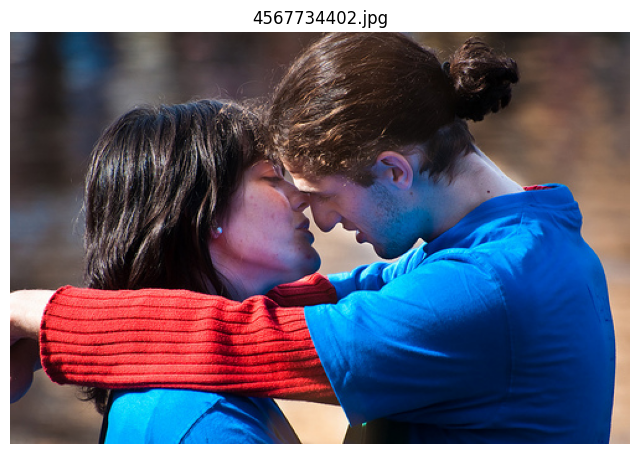

- A man in a blue and red shirt hugs a woman in a blue top .
- A man and a woman are about to kiss .
- A woman and a man getting closer .
- A couple that is about to kiss .
- Two young people are kissing .



In [11]:
processor.display_samples(1)

In [12]:
processor.prepare_captions(subset_ratio=CONFIG['subset_ratio'])[:20]

max_length set to 25
vocab size = 7719
split → train 113087 | val 14136 | test 14136


['<start> two young guys with shaggy hair look at their hands while hanging out in the yard . <end>',
 '<start> two young , white males are outside near many bushes . <end>',
 '<start> two men in green shirts are standing in a yard . <end>',
 '<start> a man in a blue shirt standing in a garden . <end>',
 '<start> several men in hard hats are operating a giant pulley system . <end>',
 '<start> workers look down from up above on a piece of equipment . <end>',
 '<start> two men working on a machine wearing hard hats . <end>',
 '<start> four men on top of a tall structure . <end>',
 '<start> three men on a large rig . <end>',
 '<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> a little girl in a pink dress going into a wooden cabin . <end>',
 '<start> a little girl climbing the stairs to her playhouse . <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a girl going into a wooden building . <end>',
 '<start> s

In [13]:
# Create datasets
train_ds, val_ds, _ = processor.prepare_datasets()

Building datasets...


In [36]:
model = ImageCaptioningModel(CONFIG, processor)
model.build_model()

Building model …
Restored: ./checkpoints/full_run/ckpt-25


In [37]:
model.summary()

Building model summaries...

Encoder Summary:
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_4 (Functional)        (None, 8, 8, 2048)        21802784  
                                                                 
 reshape_3 (Reshape)         multiple                  0         
                                                                 
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________

Bahdanau Attention Summary:
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 features (InputLayer)          [(None, 64, 2048)]   0           []                               
                                                      

In [16]:
model.prime_dataset(ds=train_ds, steps=50)

In [17]:
# model.train(train_ds, processor.val_data)

In [38]:
reduced_val = random.sample(processor.val_data, min(len(processor.val_data), 1000))

In [18]:
model.train(train_ds=train_ds, val_data=reduced_val)


Epoch 1/30  (ε=0.000)
884/884 [==============================] - 674s 707ms/step - loss: 3.1285
Grad-norm (last step): 0.75


BLEU evaluation: 100%|██████████| 200/200 [00:39<00:00,  5.13it/s]


BLEU-1: 0.5051
BLEU-2: 0.2925
BLEU-3: 0.1843
BLEU-4: 0.1246


BLEU evaluation: 100%|██████████| 1000/1000 [03:16<00:00,  5.10it/s]


BLEU-1: 0.4940
BLEU-2: 0.2726
BLEU-3: 0.1605
BLEU-4: 0.1016
Epoch 1: loss=3.2405  trainBLEU=0.1246  valBLEU=0.1016  lr=4.98e-04  time=910.5s

Epoch 2/30  (ε=0.005)
884/884 [==============================] - 121s 137ms/step - loss: 3.0798
Grad-norm (last step): 0.82


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.17it/s]


BLEU-1: 0.5240
BLEU-2: 0.3032
BLEU-3: 0.1932
BLEU-4: 0.1299


BLEU evaluation: 100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


BLEU-1: 0.5066
BLEU-2: 0.2801
BLEU-3: 0.1654
BLEU-4: 0.1062
Epoch 2: loss=3.0399  trainBLEU=0.1299  valBLEU=0.1062  lr=4.97e-04  time=356.2s

Epoch 3/30  (ε=0.010)
884/884 [==============================] - 122s 138ms/step - loss: 2.8272
Grad-norm (last step): 0.76


BLEU evaluation: 100%|██████████| 200/200 [00:35<00:00,  5.63it/s]


BLEU-1: 0.5623
BLEU-2: 0.3367
BLEU-3: 0.2181
BLEU-4: 0.1502


BLEU evaluation: 100%|██████████| 1000/1000 [02:58<00:00,  5.61it/s]


BLEU-1: 0.5496
BLEU-2: 0.3194
BLEU-3: 0.1961
BLEU-4: 0.1292
Epoch 3: loss=2.9021  trainBLEU=0.1502  valBLEU=0.1292  lr=4.94e-04  time=337.7s

Epoch 4/30  (ε=0.016)
884/884 [==============================] - 133s 150ms/step - loss: 2.7044
Grad-norm (last step): 0.87


BLEU evaluation: 100%|██████████| 200/200 [00:37<00:00,  5.31it/s]


BLEU-1: 0.5345
BLEU-2: 0.3040
BLEU-3: 0.1863
BLEU-4: 0.1225


BLEU evaluation: 100%|██████████| 1000/1000 [03:04<00:00,  5.41it/s]


BLEU-1: 0.5329
BLEU-2: 0.2938
BLEU-3: 0.1685
BLEU-4: 0.1048
Epoch 4: loss=2.7831  trainBLEU=0.1225  valBLEU=0.1048  lr=4.90e-04  time=356.6s

Epoch 5/30  (ε=0.021)
884/884 [==============================] - 133s 150ms/step - loss: 2.7143
Grad-norm (last step): 0.98


BLEU evaluation: 100%|██████████| 200/200 [00:35<00:00,  5.67it/s]


BLEU-1: 0.5501
BLEU-2: 0.3206
BLEU-3: 0.1992
BLEU-4: 0.1316


BLEU evaluation: 100%|██████████| 1000/1000 [02:54<00:00,  5.73it/s]


BLEU-1: 0.5448
BLEU-2: 0.2990
BLEU-3: 0.1706
BLEU-4: 0.1069
Epoch 5: loss=2.6663  trainBLEU=0.1316  valBLEU=0.1069  lr=4.86e-04  time=343.8s

Epoch 6/30  (ε=0.026)
884/884 [==============================] - 132s 149ms/step - loss: 2.5580
Grad-norm (last step): 0.92


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


BLEU-1: 0.5159
BLEU-2: 0.2903
BLEU-3: 0.1751
BLEU-4: 0.1147


BLEU evaluation: 100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


BLEU-1: 0.5085
BLEU-2: 0.2777
BLEU-3: 0.1592
BLEU-4: 0.0995
Epoch 6: loss=2.5428  trainBLEU=0.1147  valBLEU=0.0995  lr=4.81e-04  time=364.8s

Epoch 7/30  (ε=0.031)
884/884 [==============================] - 133s 151ms/step - loss: 2.3990
Grad-norm (last step): 1.07


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


BLEU-1: 0.5174
BLEU-2: 0.2857
BLEU-3: 0.1720
BLEU-4: 0.1115


BLEU evaluation: 100%|██████████| 1000/1000 [03:10<00:00,  5.25it/s]


BLEU-1: 0.5126
BLEU-2: 0.2757
BLEU-3: 0.1570
BLEU-4: 0.0980
Epoch 7: loss=2.4134  trainBLEU=0.1115  valBLEU=0.0980  lr=4.76e-04  time=363.5s

Epoch 8/30  (ε=0.036)
884/884 [==============================] - 134s 151ms/step - loss: 2.2163
Grad-norm (last step): 1.03


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


BLEU-1: 0.5168
BLEU-2: 0.2866
BLEU-3: 0.1701
BLEU-4: 0.1087


BLEU evaluation: 100%|██████████| 1000/1000 [03:16<00:00,  5.09it/s]


BLEU-1: 0.5070
BLEU-2: 0.2782
BLEU-3: 0.1584
BLEU-4: 0.1001
Epoch 8: loss=2.2798  trainBLEU=0.1087  valBLEU=0.1001  lr=4.69e-04  time=370.5s

Epoch 9/30  (ε=0.041)
884/884 [==============================] - 133s 150ms/step - loss: 2.1498
Grad-norm (last step): 1.15


BLEU evaluation: 100%|██████████| 200/200 [00:41<00:00,  4.84it/s]


BLEU-1: 0.4822
BLEU-2: 0.2719
BLEU-3: 0.1608
BLEU-4: 0.1042


BLEU evaluation: 100%|██████████| 1000/1000 [03:22<00:00,  4.94it/s]


BLEU-1: 0.4822
BLEU-2: 0.2630
BLEU-3: 0.1489
BLEU-4: 0.0923
Epoch 9: loss=2.1469  trainBLEU=0.1042  valBLEU=0.0923  lr=4.62e-04  time=378.0s

Epoch 10/30  (ε=0.047)
884/884 [==============================] - 134s 151ms/step - loss: 1.9182
Grad-norm (last step): 1.10


BLEU evaluation: 100%|██████████| 200/200 [00:39<00:00,  5.09it/s]


BLEU-1: 0.5113
BLEU-2: 0.2951
BLEU-3: 0.1820
BLEU-4: 0.1214


BLEU evaluation: 100%|██████████| 1000/1000 [03:15<00:00,  5.11it/s]


BLEU-1: 0.5073
BLEU-2: 0.2898
BLEU-3: 0.1728
BLEU-4: 0.1112
Epoch 10: loss=2.0163  trainBLEU=0.1214  valBLEU=0.1112  lr=4.55e-04  time=370.3s

Epoch 11/30  (ε=0.052)
884/884 [==============================] - 132s 149ms/step - loss: 1.8050
Grad-norm (last step): 1.11


BLEU evaluation: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s]


BLEU-1: 0.4975
BLEU-2: 0.2837
BLEU-3: 0.1772
BLEU-4: 0.1177


BLEU evaluation: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


BLEU-1: 0.4916
BLEU-2: 0.2711
BLEU-3: 0.1585
BLEU-4: 0.1012
Epoch 11: loss=1.8916  trainBLEU=0.1177  valBLEU=0.1012  lr=4.46e-04  time=370.0s

Epoch 12/30  (ε=0.057)
884/884 [==============================] - 127s 143ms/step - loss: 1.7992
Grad-norm (last step): 1.26


BLEU evaluation: 100%|██████████| 200/200 [00:40<00:00,  4.99it/s]


BLEU-1: 0.4892
BLEU-2: 0.2763
BLEU-3: 0.1657
BLEU-4: 0.1071


BLEU evaluation: 100%|██████████| 1000/1000 [03:17<00:00,  5.07it/s]


BLEU-1: 0.4961
BLEU-2: 0.2769
BLEU-3: 0.1623
BLEU-4: 0.1028
Epoch 12: loss=1.7734  trainBLEU=0.1071  valBLEU=0.1028  lr=4.38e-04  time=365.7s

Epoch 13/30  (ε=0.062)
884/884 [==============================] - 133s 150ms/step - loss: 1.5935
Grad-norm (last step): 1.11


BLEU evaluation: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]


BLEU-1: 0.4855
BLEU-2: 0.2666
BLEU-3: 0.1559
BLEU-4: 0.0976


BLEU evaluation: 100%|██████████| 1000/1000 [03:14<00:00,  5.13it/s]


BLEU-1: 0.4835
BLEU-2: 0.2585
BLEU-3: 0.1484
BLEU-4: 0.0935
Epoch 13: loss=1.6641  trainBLEU=0.0976  valBLEU=0.0935  lr=4.28e-04  time=368.0s

Epoch 14/30  (ε=0.067)
884/884 [==============================] - 134s 151ms/step - loss: 1.5359
Grad-norm (last step): 1.12


BLEU evaluation: 100%|██████████| 200/200 [00:40<00:00,  4.92it/s]


BLEU-1: 0.4922
BLEU-2: 0.2835
BLEU-3: 0.1762
BLEU-4: 0.1194


BLEU evaluation: 100%|██████████| 1000/1000 [03:20<00:00,  4.99it/s]


BLEU-1: 0.4814
BLEU-2: 0.2604
BLEU-3: 0.1497
BLEU-4: 0.0951
Epoch 14: loss=1.5619  trainBLEU=0.1194  valBLEU=0.0951  lr=4.18e-04  time=376.9s

Epoch 15/30  (ε=0.072)
884/884 [==============================] - 130s 147ms/step - loss: 1.3565
Grad-norm (last step): 1.10


BLEU evaluation: 100%|██████████| 200/200 [00:39<00:00,  5.10it/s]


BLEU-1: 0.4993
BLEU-2: 0.2695
BLEU-3: 0.1567
BLEU-4: 0.0991


BLEU evaluation: 100%|██████████| 1000/1000 [03:14<00:00,  5.15it/s]


BLEU-1: 0.4846
BLEU-2: 0.2583
BLEU-3: 0.1467
BLEU-4: 0.0912
Epoch 15: loss=1.4690  trainBLEU=0.0991  valBLEU=0.0912  lr=4.08e-04  time=365.2s

Epoch 16/30  (ε=0.078)
884/884 [==============================] - 131s 148ms/step - loss: 1.3082
Grad-norm (last step): 1.18


BLEU evaluation: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s]


BLEU-1: 0.4954
BLEU-2: 0.2693
BLEU-3: 0.1643
BLEU-4: 0.1104


BLEU evaluation: 100%|██████████| 1000/1000 [03:15<00:00,  5.13it/s]


BLEU-1: 0.4766
BLEU-2: 0.2514
BLEU-3: 0.1405
BLEU-4: 0.0858
Epoch 16: loss=1.3859  trainBLEU=0.1104  valBLEU=0.0858  lr=3.97e-04  time=366.9s

Epoch 17/30  (ε=0.083)
884/884 [==============================] - 132s 149ms/step - loss: 1.2493
Grad-norm (last step): 1.15


BLEU evaluation: 100%|██████████| 200/200 [00:37<00:00,  5.32it/s]


BLEU-1: 0.4894
BLEU-2: 0.2584
BLEU-3: 0.1504
BLEU-4: 0.0980


BLEU evaluation: 100%|██████████| 1000/1000 [03:09<00:00,  5.28it/s]


BLEU-1: 0.4860
BLEU-2: 0.2610
BLEU-3: 0.1500
BLEU-4: 0.0933
Epoch 17: loss=1.3095  trainBLEU=0.0980  valBLEU=0.0933  lr=3.85e-04  time=359.9s

Epoch 18/30  (ε=0.088)
884/884 [==============================] - 131s 148ms/step - loss: 1.2109
Grad-norm (last step): 1.14


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.21it/s]


BLEU-1: 0.4850
BLEU-2: 0.2539
BLEU-3: 0.1458
BLEU-4: 0.0939


BLEU evaluation: 100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


BLEU-1: 0.4836
BLEU-2: 0.2532
BLEU-3: 0.1410
BLEU-4: 0.0883
Epoch 18: loss=1.2417  trainBLEU=0.0939  valBLEU=0.0883  lr=3.73e-04  time=362.7s

Epoch 19/30  (ε=0.093)
884/884 [==============================] - 128s 145ms/step - loss: 1.1813
Grad-norm (last step): 1.15


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


BLEU-1: 0.4707
BLEU-2: 0.2479
BLEU-3: 0.1391
BLEU-4: 0.0882


BLEU evaluation: 100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


BLEU-1: 0.4636
BLEU-2: 0.2390
BLEU-3: 0.1330
BLEU-4: 0.0827
Epoch 19: loss=1.1809  trainBLEU=0.0882  valBLEU=0.0827  lr=3.61e-04  time=360.9s

Epoch 20/30  (ε=0.098)
884/884 [==============================] - 129s 146ms/step - loss: 1.0662
Grad-norm (last step): 1.05


BLEU evaluation: 100%|██████████| 200/200 [00:39<00:00,  5.04it/s]


BLEU-1: 0.4786
BLEU-2: 0.2577
BLEU-3: 0.1502
BLEU-4: 0.0951


BLEU evaluation: 100%|██████████| 1000/1000 [03:12<00:00,  5.20it/s]


BLEU-1: 0.4728
BLEU-2: 0.2470
BLEU-3: 0.1375
BLEU-4: 0.0855
Epoch 20: loss=1.1276  trainBLEU=0.0951  valBLEU=0.0855  lr=3.48e-04  time=362.7s

Epoch 21/30  (ε=0.103)
884/884 [==============================] - 134s 151ms/step - loss: 1.0872
Grad-norm (last step): 1.22


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]


BLEU-1: 0.4622
BLEU-2: 0.2370
BLEU-3: 0.1295
BLEU-4: 0.0760


BLEU evaluation: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


BLEU-1: 0.4595
BLEU-2: 0.2294
BLEU-3: 0.1236
BLEU-4: 0.0738
Epoch 21: loss=1.0795  trainBLEU=0.0760  valBLEU=0.0738  lr=3.35e-04  time=368.3s

Epoch 22/30  (ε=0.109)
884/884 [==============================] - 129s 145ms/step - loss: 1.0289
Grad-norm (last step): 1.20


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.15it/s]


BLEU-1: 0.4617
BLEU-2: 0.2392
BLEU-3: 0.1365
BLEU-4: 0.0841


BLEU evaluation: 100%|██████████| 1000/1000 [03:12<00:00,  5.19it/s]


BLEU-1: 0.4639
BLEU-2: 0.2362
BLEU-3: 0.1302
BLEU-4: 0.0792
Epoch 22: loss=1.0377  trainBLEU=0.0841  valBLEU=0.0792  lr=3.22e-04  time=361.4s

Epoch 23/30  (ε=0.114)
884/884 [==============================] - 132s 149ms/step - loss: 0.9668
Grad-norm (last step): 1.03


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s]


BLEU-1: 0.4600
BLEU-2: 0.2408
BLEU-3: 0.1363
BLEU-4: 0.0857


BLEU evaluation: 100%|██████████| 1000/1000 [03:11<00:00,  5.21it/s]


BLEU-1: 0.4724
BLEU-2: 0.2476
BLEU-3: 0.1391
BLEU-4: 0.0887
Early stopping (no BLEU gain for 20 epochs)


([3.240469775048856,
  3.0398644074055943,
  2.9020838915492613,
  2.7830676209872665,
  2.6662606402759637,
  2.5428135546084443,
  2.413407435783973,
  2.279770792609426,
  2.146930393320403,
  2.0163142128228064,
  1.8916320980134593,
  1.7733502866725577,
  1.6640952020479003,
  1.561940120895524,
  1.4690367189737468,
  1.3858588460613699,
  1.309489934153147,
  1.241693908947086,
  1.1808631474076352,
  1.1275585243874546,
  1.079486521053638,
  1.0377110650771344,
  0.9980524698129067],
 [0.10160095783675993,
  0.10622305054840535,
  0.12915201355778932,
  0.10479186138468376,
  0.1068595755753935,
  0.099526977714761,
  0.09798398031749128,
  0.10010762905263368,
  0.09233259979838103,
  0.11118217323372048,
  0.10124345228079842,
  0.10276994524002005,
  0.09347187352661358,
  0.09509956519763656,
  0.09118133351232358,
  0.0857778912329077,
  0.09332726785794937,
  0.0882953701771091,
  0.08274342479143386,
  0.08551550613274704,
  0.07375774035837676,
  0.07918847629290028,


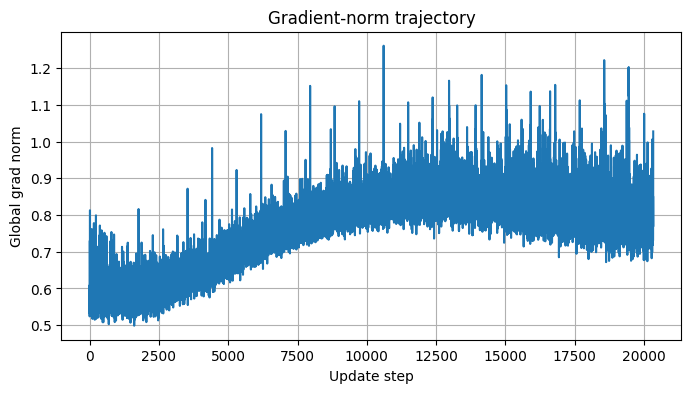

In [19]:
model.plot_grad_norms()

In [39]:
model.fine_tune_cnn(train_ds, reduced_val, layers_to_unfreeze=8, lr=1e-5, epochs=5)


Unfreezing top 8 Inception blocks …
Fine-tuning CNN for 5 epoch(s) at lr=1e-05 …

Epoch 1/5 (ε=0.000)
884/884 [==============================] - 142s 156ms/step - loss: 0.7997


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s]


BLEU-1: 0.4721
BLEU-2: 0.2413
BLEU-3: 0.1337
BLEU-4: 0.0801


BLEU evaluation: 100%|██████████| 1000/1000 [03:13<00:00,  5.16it/s]


BLEU-1: 0.4665
BLEU-2: 0.2388
BLEU-3: 0.1306
BLEU-4: 0.0794
Epoch 1: loss=0.8906  trainBLEU=0.0801  valBLEU=0.0794  lr=1.00e-05  time=375.7s

Epoch 2/5 (ε=0.037)
884/884 [==============================] - 135s 153ms/step - loss: 0.8457


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s]


BLEU-1: 0.4693
BLEU-2: 0.2412
BLEU-3: 0.1287
BLEU-4: 0.0699


BLEU evaluation: 100%|██████████| 1000/1000 [03:12<00:00,  5.21it/s]


BLEU-1: 0.4664
BLEU-2: 0.2401
BLEU-3: 0.1326
BLEU-4: 0.0819
Epoch 2: loss=0.8596  trainBLEU=0.0699  valBLEU=0.0819  lr=1.00e-05  time=367.6s

Epoch 3/5 (ε=0.075)
884/884 [==============================] - 136s 153ms/step - loss: 0.8486


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.24it/s]


BLEU-1: 0.4777
BLEU-2: 0.2439
BLEU-3: 0.1324
BLEU-4: 0.0757


BLEU evaluation: 100%|██████████| 1000/1000 [03:10<00:00,  5.24it/s]


BLEU-1: 0.4684
BLEU-2: 0.2410
BLEU-3: 0.1328
BLEU-4: 0.0817
Epoch 3: loss=0.8500  trainBLEU=0.0757  valBLEU=0.0817  lr=1.00e-05  time=366.3s

Epoch 4/5 (ε=0.112)
884/884 [==============================] - 136s 153ms/step - loss: 0.8169


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.24it/s]


BLEU-1: 0.4751
BLEU-2: 0.2417
BLEU-3: 0.1280
BLEU-4: 0.0701


BLEU evaluation: 100%|██████████| 1000/1000 [03:11<00:00,  5.22it/s]


BLEU-1: 0.4657
BLEU-2: 0.2401
BLEU-3: 0.1327
BLEU-4: 0.0810
Epoch 4: loss=0.8443  trainBLEU=0.0701  valBLEU=0.0810  lr=1.00e-05  time=367.1s

Epoch 5/5 (ε=0.150)
884/884 [==============================] - 135s 152ms/step - loss: 0.8127


BLEU evaluation: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s]


BLEU-1: 0.4698
BLEU-2: 0.2391
BLEU-3: 0.1298
BLEU-4: 0.0766


BLEU evaluation: 100%|██████████| 1000/1000 [03:12<00:00,  5.19it/s]


BLEU-1: 0.4658
BLEU-2: 0.2391
BLEU-3: 0.1316
BLEU-4: 0.0803
Epoch 5: loss=0.8401  trainBLEU=0.0766  valBLEU=0.0803  lr=1.00e-05  time=367.9s
CNN fine-tune finished.


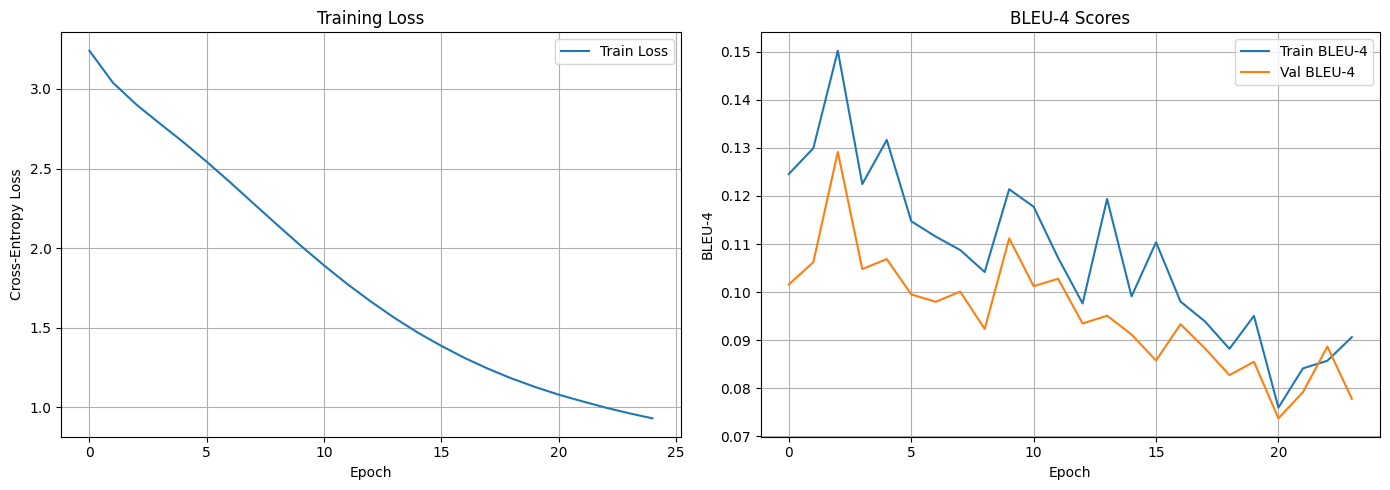

In [22]:
model.plot_history()

In [ ]:
model.evaluate_bleu(processor.test_data)

In [40]:
samples = processor.train_data[:5]  # known to be from training set
for img_name, _ in samples:
    img_path = os.path.join(CONFIG['image_dir'], img_name)
    pred = model.greedy_decode(img_path)
    print ('------------')
    print("Predicted:", ' '.join(pred))
    print("Ground Truth:", processor.captions_dict[img_name][:1])

------------
Predicted: a man in a green shirt is cutting the hair of another man in a striped shirt .
Ground Truth: ['A woman in a white shirt and sunglasses sits outside in a chair with a baby on her lap .']
------------
Predicted: a man in a red shirt and white shorts is walking next to a man in a blue shirt on a bike .
Ground Truth: ['Marathon runners are racing on a city street , with other people standing around .']
------------
Predicted: a woman in a white dress is singing and a man is playing a guitar .
Ground Truth: ['A young girl wearing pink is pushing a green wheelbarrow with a young blond boy in it .']
------------
Predicted: a man in a uniform waves at a crowded baseball
Ground Truth: ['A young oriental girl and another person are watching a young toddler dressed in a pink sweater and white knit cap .']
------------
Predicted: a man wearing a construction hat and a blue jeans is standing in front of a blue door .
Ground Truth: ['A man in a blue jacket sits on a wooden be

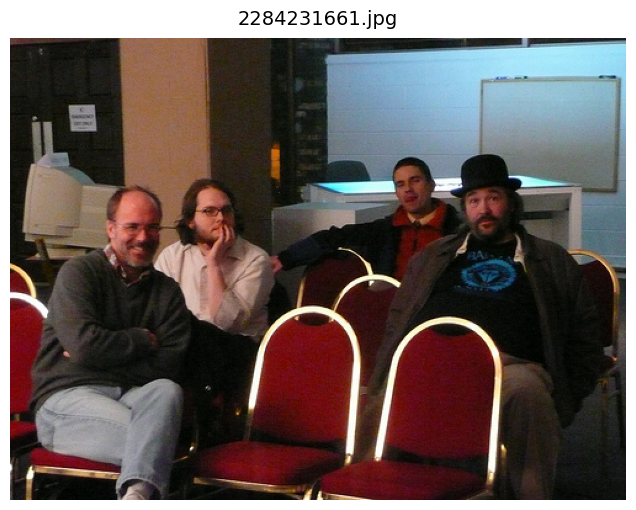

Ground-truth captions:
 - Four men are sitting in red cloth covered chairs viewing something together .
 - 4 nerds sitting down posing for a picture .
 - A group of men sitting on red chairs .
 - Four happy people sitting in chairs .
 - Four men are sitting in red chairs .

Generated caption:
man with glasses and glasses looking through a window .


Audio saved to caption_audio01.mp3


/tmp/ipykernel_1643/1968850546.py:384: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  alpha_resized = Image.fromarray(np.uint8(255 * alpha)).resize((299, 299), resample=Image.BICUBIC)


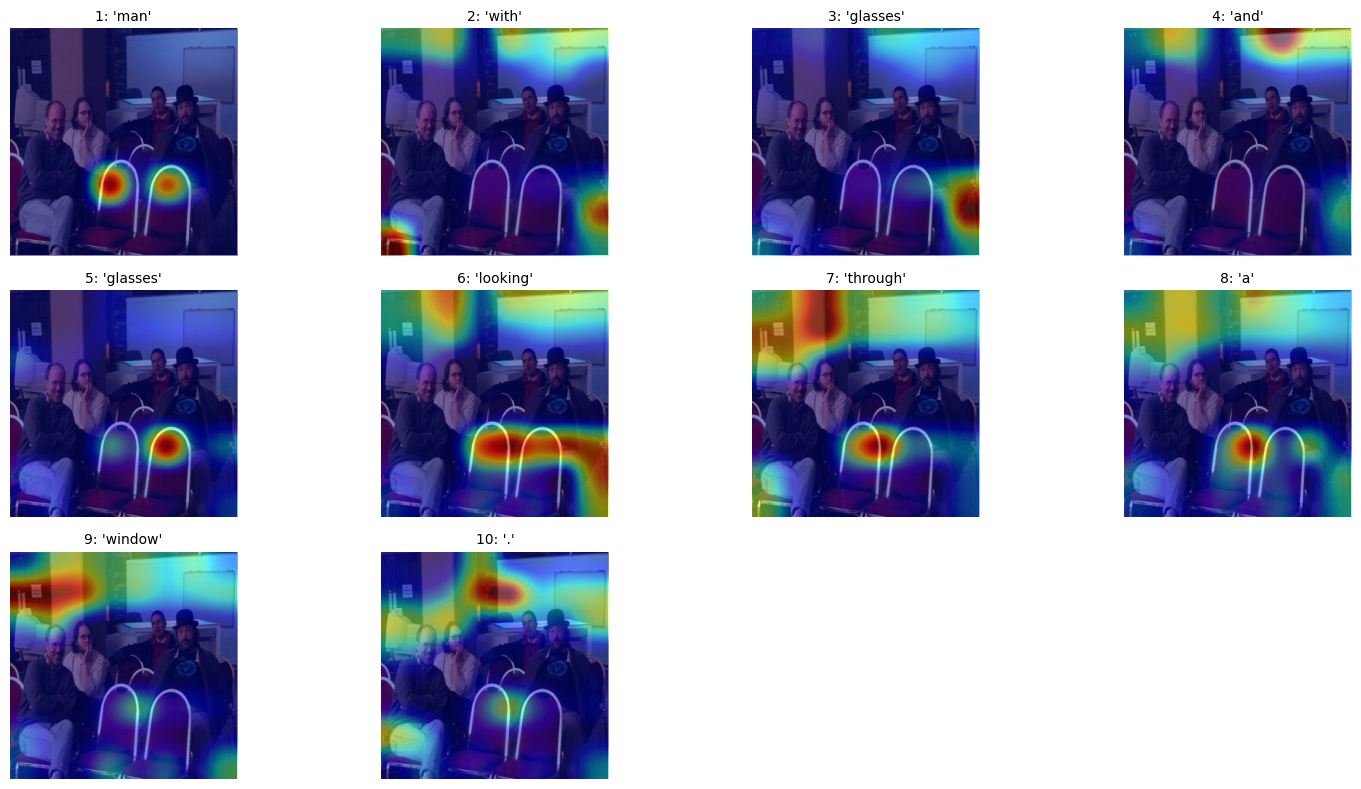

In [41]:
sample_pair = random.choice(processor.test_data)
sample_img = os.path.join(CONFIG['image_dir'], sample_pair[0])
model.demo(sample_img, filename='caption_audio01.mp3')

In [ ]:
for batch in train_ds.take(1):
    img_tensor, tok_ids, _, filenames = batch
    fname = filenames[0].numpy().decode()

    decoded = ' '.join(
        processor.tokenizer.index_word.get(int(i), '')
        for i in tok_ids[0].numpy() if i)

    print("Filename :", fname)
    print("Caption  :", decoded)
    print("GT       :", processor.captions_dict[fname][0])